Found 1153 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Epoch 1/30
73/73 [==============================] - 13s 109ms/step - loss: 0.6811 - accuracy: 0.5854 - val_loss: 0.6621 - val_accuracy: 0.5993
Epoch 2/30
73/73 [==============================] - 7s 94ms/step - loss: 0.6618 - accuracy: 0.6071 - val_loss: 0.6424 - val_accuracy: 0.6098
Epoch 3/30
73/73 [==============================] - 7s 92ms/step - loss: 0.6328 - accuracy: 0.6539 - val_loss: 0.6616 - val_accuracy: 0.6063
Epoch 4/30
73/73 [==============================] - 7s 91ms/step - loss: 0.5945 - accuracy: 0.6990 - val_loss: 0.6910 - val_accuracy: 0.5470
Epoch 5/30
73/73 [==============================] - 7s 89ms/step - loss: 0.5495 - accuracy: 0.7216 - val_loss: 0.7047 - val_accuracy: 0.6028
Epoch 6/30
73/73 [==============================] - 7s 94ms/step - loss: 0.4861 - accuracy: 0.7684 - val_loss: 0.8068 - val_accuracy: 0.5296
Epoch 7/30
73/73 [==============================] - 6s 89ms/step - lo

C:\Users\KIIT\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


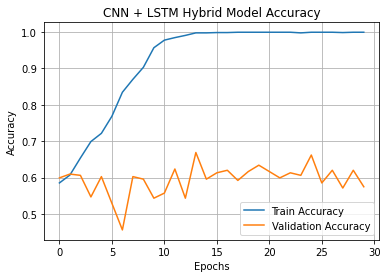

18/18 [==============================] - 1s 33ms/step
Accuracy: 0.5436
Precision: 0.6145
Recall (Sensitivity): 0.6395
F1 Score: 0.6268
AUC-ROC: 0.5409
Specificity: 0.4000
K-score: 0.5436


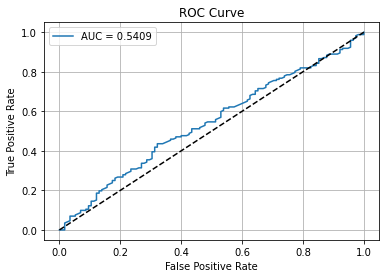

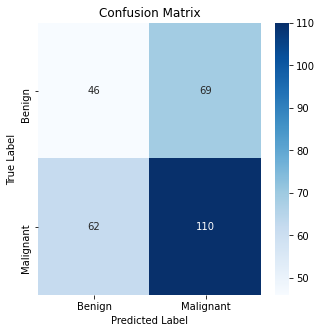

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define constants
IMG_SIZE = (64, 64)  # Reduced size for efficiency
BATCH_SIZE = 16
EPOCHS = 30

# Data Generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    'augmented_images',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    'augmented_images',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# CNN + LSTM Model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(1, IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Function to reshape data for CNN+LSTM
def reshape_generator(generator):
    while True:
        x, y = next(generator)
        x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], x.shape[3]))  # Reshape to (batch, time, h, w, c)
        yield x, y

# Train the model
history = model.fit(
    reshape_generator(train_data),
    steps_per_epoch=len(train_data),
    validation_data=reshape_generator(val_data),
    validation_steps=len(val_data),
    epochs=EPOCHS
)

# Save model
model.save('cnn_lstm_hybrid_model.h5')

# Plot Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + LSTM Hybrid Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model - Get Predictions
y_true = val_data.classes
y_pred_prob = model.predict(reshape_generator(val_data), steps=len(val_data))
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
k_score = (tp + tn) / (tp + tn + fp + fn)  # Kappa Score approximation

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"K-score: {k_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
